📢 해당 게시물은 파이토치 공식 튜토리얼 중 [파이토치 기본 익히기(QuickStart)](https://tutorials.pytorch.kr/beginner/basics/quickstart_tutorial.html)와 PyTorch로 시작하는 딥 러닝 입문 > [커스텀 데이터셋](https://wikidocs.net/57165)를 재구성하여 작성되었습니다.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader # Dataset을 순회 가능한 객체(iterable)로 감쌈
from torchvision import datasets # 샘플과 정답(label) 저장
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

'''
Pytorch는 TorchText, TorchVision, TorchAudio와 같이
도메인 특화 라이브러리를 데이터셋(ex. FashionMNIST)과 함께 제공하는데,
여기선 TorchVision 데이터셋을 사용함
'''

'\nPytorch는 TorchText, TorchVision, TorchAudio와 같이\n도메인 특화 라이브러리를 데이터셋(ex. FashionMNIST)과 함께 제공하는데,\n여기선 TorchVision 데이터셋을 사용함\n'

파이토치 가이드([link](https://tutorials.pytorch.kr/beginner/basics/quickstart_tutorial.html))를 보면서 각 코드가 의미하는 바를 주석을 달아 해석하세요.

# 1. 데이터 불러오기

`Fashion-MNIST`
- 60,000개의 학습 예제와 10,000개의 테스트 예제로 이루어짐
- 흑백의 28x28 이미지와 10개의 분류(class) 중 하나인 정답(label)로 구성

In [2]:
# 공개된 데이터셋에서 학습 데이터 내려받기 (패션 MNIST)
training_data = datasets.FashionMNIST(
    root="data", # 데이터가 저장되는 경로
    train=True, # 학습 데이터
    download=True, # root에 데이터 없다면 다운로드 받겠다.
    transform=ToTensor(), # transform: 특징(feature)과 정답(label) 변형(transform)을 지정
                          # numpy 이미지에 torch 이미지로 변경 (축변환)
)

'''
일반 이미지: 0-255 (높이, 너비, 채널)
파이토치 이미지: 0-1 (채널, 높이, 너비)
'''

# 공개된 데이터셋에서 테스트 데이터 내려받기 (패션 MNIST)
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # test 데이터 불러오기
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64 # 배치 사이즈 (연산 한 번에 들어갈 크기)

# 데이터로더 생성
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [4]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

## 1-1. 시각화하기

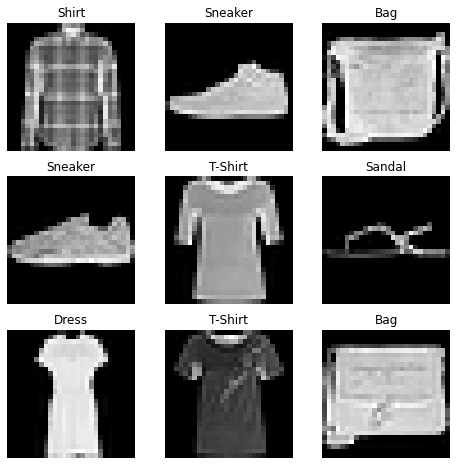

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1): # 총 9개의 이미지
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # randint - size(1,): 1개의 랜덤 숫자 반환
                                                                     # .item(): 텐서 형태의 숫자에서 값만 반환
    img, label = training_data[sample_idx] # 샘플 이미지와 라벨
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label]) # 라벨에 map 되는 이름
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 1-2. 사용자 정의 데이터셋 생성

사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 함
- `__ini__`
- `__len__`
- `__getitem__`

- FashionMNIST 이미지들은 `img_dir`에 저장되고, 정답은 `annotations_file` csv 파일에 별도로 저장

In [7]:
import os
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import Dataset

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label']) # 정답은 annotaions_file에
        self.img_dir = img_dir      # FashionMNIST 이미지들이 'img_dir'에 저장됨
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels) # 데이터셋의 샘플 개수 반환

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) # 경로 합치기
        image = read_image(img_path)             # 이미지를 텐서로 변환
        label = self.img_labels.iloc[idx, 1]     # csv 데이터로부터 해당하는 label 가져와
        if self.transform:
            image = self.transform(image)        # 텐서 이미지 dict형 변환
        if self.target_transform:
            label = self.target_transform(label) # 텐서 라벨 dict형 변환
        return image, label

**✔️ `__init__`**
- Dataset 객체가 생성될 때 한 번 실행
- 이미지, 주석 파일(annotation_file)이 포함된 디렉토리, 두 가지 변형(transform)을 초기화 ❓

<br/>

**✔️ `__len__`**
- 데이터셋의 샘플 개수 반환

<br/>

**✔️ `__getitem__`**
- 주어진 인덱스 `idx`에 해당하는 샘플을 데이터셋에서 불러와 반환
- 인덱스를 기반으로 디스크에서 이미지의 위치 식별
- `read_image()`: 이미지를 텐서로 변환
- `self.image_labels`: csv 데이터로부터 해당하는 label 가져와
- (해당하는 경우) transform 함수들을 호출한 뒤 텐서 이미지와 라벨을 python 사전(dict)형으로 변환

# 2. 모델 생성

신경망은 데이터 연산을 수행하는 계층(layer)와 모듈(module)로 구성됨
- `torch.nn`: 신경망을 구성하는데 필요한 모든 구성 요소 제공
- Pytorch의 모든 모듈은 `nn.Module`의 하위 클래스

In [9]:
# 학습에 사용할 CPU나 GPU 장치 얻기
device = "cuda" if torch.cuda.is_available() else "cpu" # cuda 이용 가능하면 이용해라
print(f"Using {device} device")

Using cpu device


Pytorch 신경망 모델은 `nn.Module`을 상속받는 class를 생성해 정의함
- `__init__`: 신경망의 layer 정의(초기화)
- `forward`: 신경망에 데이터 어떻게 전달할지 지정 (입력 데이터에 대한 연산들 구현)

In [10]:
# 모델 정의
class NeuralNetwork(nn.Module): ## nn.Module 상속
    def __init__(self): # 신경망 계층들 초기화
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x): # 입력 데이터에 대한 연산 구현
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# NeuralNetwork의 인스턴스를 생성하고, 이를 device로 이동
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## 2-1. 모델 layer 살펴보기

- input data

In [11]:
input_image = torch.rand(3, 28, 28) # 28x28 크기의 이미지 3개로 구성된 미니배치
print(input_image.size())

torch.Size([3, 28, 28])


- nn.Flatten

In [12]:
flatten = nn.Flatten() # 28x28 이미지를 784 픽셀 값을 갖는 연속된 배열로 변환
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


- nn.Linear
    - 저장된 가중치(weight), 편향(bias)을 사용해 입력에 선형 변환을 적용하는 모듈

In [13]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


- nn.ReLU
    - 비선형 활성화(activation)
    - 선형 변환 후 적용되어 비선형성(nonlinearity)을 도입해 신경망이 다양한 현상을 학습할 수 있도록 함

In [14]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.0969, -0.4395, -0.6826, -0.0530,  0.2140,  0.3942,  0.3998, -0.4917,
          0.1434, -0.1680, -0.1268, -0.0221, -0.2505,  0.2404,  0.0672,  0.0177,
         -0.2052, -0.0574, -0.3038, -0.0950],
        [ 0.0115,  0.1144, -0.5097,  0.2851,  0.2023,  0.1432,  0.2941, -0.5683,
         -0.0736, -0.4551, -0.0195,  0.3386, -0.3301, -0.0983, -0.0522, -0.0882,
         -0.6140, -0.5775, -0.3474,  0.0871],
        [-0.0958, -0.0316, -0.4162,  0.3111,  0.2581, -0.1699,  0.4884, -0.3519,
         -0.2801, -0.3984,  0.1786,  0.0311, -0.0774, -0.2955, -0.0681,  0.1218,
         -0.4814, -0.1693, -0.3595,  0.3210]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0969, 0.0000, 0.0000, 0.0000, 0.2140, 0.3942, 0.3998, 0.0000, 0.1434,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2404, 0.0672, 0.0177, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0115, 0.1144, 0.0000, 0.2851, 0.2023, 0.1432, 0.2941, 0.0000, 0.0000,
         0.0000, 0.0000, 0.3386, 0.0000, 0.0000, 0.00

- nn.Sequential
    - 순서를 갖는 모듈의 컨테이너 (정의된 데이터와 같은 순서로 모든 모듈들을 통해 전달됨)
    - 순차 컨테이너(sequential container)를 사용해 아래의 `seq_modules`와 같은 신경망을 빠르게 만들 수 있음

In [15]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3, 28, 28)
logits = seq_modules(input_image)

- nn.Softmax
    - 선형 계층
    - logits는 각 class에 대한 예측 확률을 나타내도록 [0, 1] 범위로 비례하여 scaling됨
    - `dim=1`: 값의 합이 1이 되는 차원

In [16]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

**모델 매개변수** <br/>
- 신경망 내부의 많은 계층들은 매개변수화(parameterize)되는데, 학습 중 최적화되는 가중치&편향과 연관지어짐
- `nn.Module`을 상속하면 모든 매개변수에 접근 가능

In [17]:
print("Model structure: ", model, "\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure:  NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
) 


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0137,  0.0335,  0.0342,  ..., -0.0266, -0.0042, -0.0032],
        [-0.0334,  0.0130,  0.0188,  ...,  0.0147,  0.0144,  0.0303]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0015, -0.0025], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0406,  0.0317, -0.0138,  ...,  0.0008,  0.0066,  0.0338],
        [ 0.0369, -0.0069,  0.0187,  ...,  0.0085,  0.0299, -0.0211]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias 

# 3. 최적화
- 손실 함수(loss function)
    - 획득 결과 & 실제 값 사이의 오차 측정해 최소화
- 옵티마이저(optimizer)
    - 모델의 오류 줄이기 위해 모델 매개변수 조정
    - 여기선 SGD 옵티마이저를 사용 (ADAM, RMSProp 등)

In [18]:
loss_fn = nn.CrossEntropyLoss() # 손실 함수 초기화
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # 옵티마이저 초기화

In [19]:
# train 단계 - batch로 제공되는 학습 데이터셋에 대한 예측 수행
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측(prediction)과 손실(loss) 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad() # 모델 매개변수의 변화도 재설정 (반복할 때마다 0으로 설정)
        loss.backward() # 예측 손실 역전파 (손실의 변화도 저장)
        optimizer.step() # 매개변수 조정

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [20]:
# test 단계 - 모델의 성능 측정
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [21]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306304  [    0/60000]
loss: 2.286146  [ 6400/60000]
loss: 2.264614  [12800/60000]
loss: 2.257558  [19200/60000]
loss: 2.249856  [25600/60000]
loss: 2.208612  [32000/60000]
loss: 2.233075  [38400/60000]
loss: 2.197759  [44800/60000]
loss: 2.195766  [51200/60000]
loss: 2.153446  [57600/60000]
Test Error: 
 Accuracy: 39.8%, Avg loss: 2.153345 

Epoch 2
-------------------------------
loss: 2.169347  [    0/60000]
loss: 2.152699  [ 6400/60000]
loss: 2.094894  [12800/60000]
loss: 2.112800  [19200/60000]
loss: 2.071683  [25600/60000]
loss: 1.994548  [32000/60000]
loss: 2.040152  [38400/60000]
loss: 1.957438  [44800/60000]
loss: 1.967221  [51200/60000]
loss: 1.885943  [57600/60000]
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.888513 

Epoch 3
-------------------------------
loss: 1.921727  [    0/60000]
loss: 1.884664  [ 6400/60000]
loss: 1.775232  [12800/60000]
loss: 1.821755  [19200/60000]
loss: 1.723053  [25600/60000]
loss: 1.651689  [32000/600

# 4. 모델 저장 및 불러오기
- 학습한 매개변수를 `state_dict`라 불리는 내부 상태 사전에 저장
- 이 값들은 `torch.save` 메소드를 통해 저장할 수 있음

In [22]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [23]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [24]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# 5. 커스텀 데이터셋(Custom Dataset)

PyTorch로 시작하는 딥 러닝 입문 > 커스텀 데이터셋([link](https://wikidocs.net/57165))을 읽고 코드들의 해석을 주석 달아주세요.

## 5-1. 커스텀 데이터셋 생성
- `torch.utils.data.Dataset`: 파이토치에서 데이터셋 제공하는 추상 클래스
- 이를 상속받아 직접 커스텀 데이터셋 만들기

In [27]:
# class CustomDataset(torch.utils.data.Dataset): 
#   def __init__(self): // 데이터셋 전처리

#   def __len__(self): // 데이터셋 길이 (총 샘플의 수)

#   def __getitem__(self, idx): // 데이터셋에서 특정 1개의 샘플 가져오기

## 5-2. 커스텀 데이터셋(Custom Dataset)으로 선형 회귀 구현하기

In [28]:
import torch
import torch.nn.functional as F

In [29]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [30]:
# Dataset 상속
class CustomDataset(Dataset): 
    def __init__(self):
        self.x_data = [[73, 80, 75],
                       [93, 88, 93],
                       [89, 91, 90],
                       [96, 98, 100],
                       [73, 66, 70]]
        self.y_data = [[152], [185], [180], [196], [142]]
        
    # 총 데이터의 개수 리턴
    def __len__(self): 
        return len(self.x_data)
    
    # 인덱스를 입력 받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx): 
        x = torch.FloatTensor(self.x_data[idx])
        y = torch.FloatTensor(self.y_data[idx])
        return x, y

In [31]:
dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [32]:
model = torch.nn.Linear(3,1)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5) 

In [33]:
nb_epochs = 20
for epoch in range(nb_epochs + 1):
    for batch_idx, samples in enumerate(dataloader):
        # print(batch_idx)
        # print(samples)
        x_train, y_train = samples
        # H(x) 계산
        prediction = model(x_train)

        # cost 계산
        cost = F.mse_loss(prediction, y_train)

        # cost로 H(x) 계산
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, batch_idx+1, len(dataloader),
            cost.item()
            ))

Epoch    0/20 Batch 1/3 Cost: 91446.250000
Epoch    0/20 Batch 2/3 Cost: 15287.585938
Epoch    0/20 Batch 3/3 Cost: 12408.942383
Epoch    1/20 Batch 1/3 Cost: 1330.381348
Epoch    1/20 Batch 2/3 Cost: 995.255005
Epoch    1/20 Batch 3/3 Cost: 168.557144
Epoch    2/20 Batch 1/3 Cost: 50.599651
Epoch    2/20 Batch 2/3 Cost: 12.733994
Epoch    2/20 Batch 3/3 Cost: 15.750250
Epoch    3/20 Batch 1/3 Cost: 1.962050
Epoch    3/20 Batch 2/3 Cost: 0.250953
Epoch    3/20 Batch 3/3 Cost: 4.606675
Epoch    4/20 Batch 1/3 Cost: 1.386089
Epoch    4/20 Batch 2/3 Cost: 1.375750
Epoch    4/20 Batch 3/3 Cost: 1.040440
Epoch    5/20 Batch 1/3 Cost: 0.393456
Epoch    5/20 Batch 2/3 Cost: 3.994439
Epoch    5/20 Batch 3/3 Cost: 0.430904
Epoch    6/20 Batch 1/3 Cost: 0.794641
Epoch    6/20 Batch 2/3 Cost: 2.012249
Epoch    6/20 Batch 3/3 Cost: 0.935995
Epoch    7/20 Batch 1/3 Cost: 2.065451
Epoch    7/20 Batch 2/3 Cost: 0.829709
Epoch    7/20 Batch 3/3 Cost: 1.440908
Epoch    8/20 Batch 1/3 Cost: 0.130154
Epo

In [34]:
new_var = torch.FloatTensor([[73, 80, 75]]) # 임의의 입력
pred_y = model(new_var) # 입력한 값에 대해 예측값 리턴 받음
print("훈련 후 입력이 73, 80, 75일 때의 예측값 :", pred_y) 

훈련 후 입력이 73, 80, 75일 때의 예측값 : tensor([[152.4129]], grad_fn=<AddmmBackward0>)
